3.-Pipeline ETL + EDA (RA2)


In [ ]:
 Ingesta de datos

In [ ]:
# Importamos las librerías principales de Python para ciencia de datos
!pip install upsetplot
!pip install matplotlib-venn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import from_indicators, UpSet
from matplotlib_venn import venn2, venn3

# Configuramos el estilo de los gráficos para una visualización más profesional
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
sns.set_style("white")
plt.rcParams['figure.figsize'] = [12, 8]  # Aumentamos el tamaño por defecto
plt.rcParams['figure.dpi'] = 120          # Aumentamos la resolución
pd.options.display.float_format = '{:,.2f}'.format # Formato de decimales

print("Librerías importadas y configuraciones aplicadas.")

In [2]:

import requests

# Para descargar datos de cBioPortal
BASE = "https://www.cbioportal.org/api"
HEADERS = {"accept": "application/json"}

def api_get(path, **params):
    r = requests.get(f"{BASE}{path}", params=params, headers=HEADERS)
    r.raise_for_status()
    return r.json()

def api_post(path, payload, **params):
    h = {**HEADERS, "Content-Type": "application/json"}
    r = requests.post(f"{BASE}{path}", params=params, json=payload, headers=h)
    r.raise_for_status()
    return r.json()

# catastro de estudios (resumen)
studies = pd.DataFrame(api_get("/studies", projection="SUMMARY"))

Estudio MSK-IMPACT Clinical Sequencing Cohort de cBioPortal.

In [3]:
# estudio de interes por el ID
study_id = "msk_impact_2017"
print("Elegido:", study_id)

Elegido: msk_impact_2017


In [12]:
# Primero listamos los atributos clínicos definidos a nivel paciente (también puedes usar entityType="SAMPLE" para nivel muestra):
attrs_pat = pd.DataFrame(
    api_get(f"/studies/{study_id}/clinical-attributes", entityType="PATIENT")
)
display(attrs_pat.head(15))

# mira sólo los IDs de atributo:
attrs_pat_ids = set(attrs_pat["clinicalAttributeId"])
print(list(sorted(attrs_pat_ids))[:25])


,displayName,description,datatype,patientAttribute,priority,clinicalAttributeId,studyId
0,Cancer Type,Cancer Type,STRING,False,1,CANCER_TYPE,msk_impact_2017
1,Cancer Type Detailed,Cancer Type Detailed,STRING,False,1,CANCER_TYPE_DETAILED,msk_impact_2017
2,DNA Input,DNA Input,NUMBER,False,1,DNA_INPUT,msk_impact_2017
3,Fraction Genome Altered,Fraction Genome Altered,NUMBER,False,20,FRACTION_GENOME_ALTERED,msk_impact_2017
4,Matched Status,Matched Status,STRING,False,1,MATCHED_STATUS,msk_impact_2017
5,Metastatic Site,The anatomic location to which the cancer has ...,STRING,False,1,METASTATIC_SITE,msk_impact_2017
6,Mutation Count,Mutation Count,NUMBER,False,30,MUTATION_COUNT,msk_impact_2017
7,Oncotree Code,Oncotree Code,STRING,False,1,ONCOTREE_CODE,msk_impact_2017
8,Overall Survival (Months),Overall survival in months since date of sampl...,NUMBER,True,1,OS_MONTHS,msk_impact_2017
9,Overall Survival Status,Overall patient survival status.,STRING,True,1,OS_STATUS,msk_impact_2017


['CANCER_TYPE', 'CANCER_TYPE_DETAILED', 'DNA_INPUT', 'FRACTION_GENOME_ALTERED', 'MATCHED_STATUS', 'METASTATIC_SITE', 'MUTATION_COUNT', 'ONCOTREE_CODE', 'OS_MONTHS', 'OS_STATUS', 'PRIMARY_SITE', 'SAMPLE_CLASS', 'SAMPLE_COLLECTION_SOURCE', 'SAMPLE_COUNT', 'SAMPLE_COVERAGE', 'SAMPLE_TYPE', 'SEX', 'SMOKING_HISTORY', 'SOMATIC_STATUS', 'SPECIMEN_PRESERVATION_TYPE', 'SPECIMEN_TYPE', 'TMB_NONSYNONYMOUS', 'TUMOR_PURITY', 'VITAL_STATUS']


In [6]:
# Lista de pacientes
patients = pd.DataFrame(api_get(f"/studies/{study_id}/patients", projection="SUMMARY"))
patient_ids = patients["patientId"].tolist()
print(f"Pacientes: {len(patient_ids)}")

Pacientes: 10336


In [90]:
# Pedimos clínica básica a nivel PACIENTE 
attrs = ["OS_MONTHS", "OS_STATUS", "SEX", "SMOKING_HISTORY"]

In [91]:
# ID puede llamarse patientId o entityId según el endpoint
id_col = "patientId" if "patientId" in raw.columns else "entityId"

# Una fila por paciente
wide = (raw[raw["clinicalAttributeId"].isin(attrs)]
          [[id_col, "clinicalAttributeId", "value"]]
          .pivot_table(index=id_col, columns="clinicalAttributeId", values="value", aggfunc="first"))

In [92]:
# Limpiar tipos y crear evento
wide["OS_MONTHS"] = pd.to_numeric(wide.get("OS_MONTHS"), errors="coerce")
wide["OS_EVENT"]  = wide.get("OS_STATUS").astype(str).str.contains("DECEASED", case=False, na=False)

In [93]:
# Vista rápida
wide[["OS_MONTHS","OS_STATUS","SEX","SMOKING_HISTORY"]].head()

clinicalAttributeId,OS_MONTHS,OS_STATUS,SEX,SMOKING_HISTORY
patientId,,,,
P-0000004,NaN,0:LIVING,Female,Unknown
P-0000015,NaN,1:DECEASED,Female,Never
P-0000023,8.71,1:DECEASED,Male,Never
P-0000024,36.75,0:LIVING,Female,Prev/Curr Smoker
P-0000025,8.81,0:LIVING,Female,Never


In [87]:
print(wide.columns.tolist())

['OS_MONTHS', 'OS_STATUS', 'SEX', 'SMOKING_HISTORY', 'OS_EVENT']


In [16]:
print("--- Información General del DataFrame ---")

wide.info()
wide.head()

--- Información General del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 10336 entries, P-0000004 to P-0012622
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   OS_MONTHS        7574 non-null   float64
 1   OS_STATUS        10335 non-null  object 
 2   SEX              10336 non-null  object 
 3   SMOKING_HISTORY  10335 non-null  object 
 4   OS_EVENT         10336 non-null  bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 413.8+ KB


clinicalAttributeId,OS_MONTHS,OS_STATUS,SEX,SMOKING_HISTORY,OS_EVENT
patientId,,,,,
P-0000004,NaN,0:LIVING,Female,Unknown,False
P-0000015,NaN,1:DECEASED,Female,Never,True
P-0000023,8.71,1:DECEASED,Male,Never,True
P-0000024,36.75,0:LIVING,Female,Prev/Curr Smoker,False
P-0000025,8.81,0:LIVING,Female,Never,False


In [17]:
# Estadísticos básicos de OS (count, mean, std, min, Q1, mediana, Q3, max)
wide[["OS_MONTHS"]].describe()

clinicalAttributeId,OS_MONTHS
count,"7,574.00"
mean,12.27
std,7.72
min,0.00
25%,6.42
50%,10.98
75%,17.06
max,40.40


In [32]:
plt.figure(figsize=(10, 6))

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

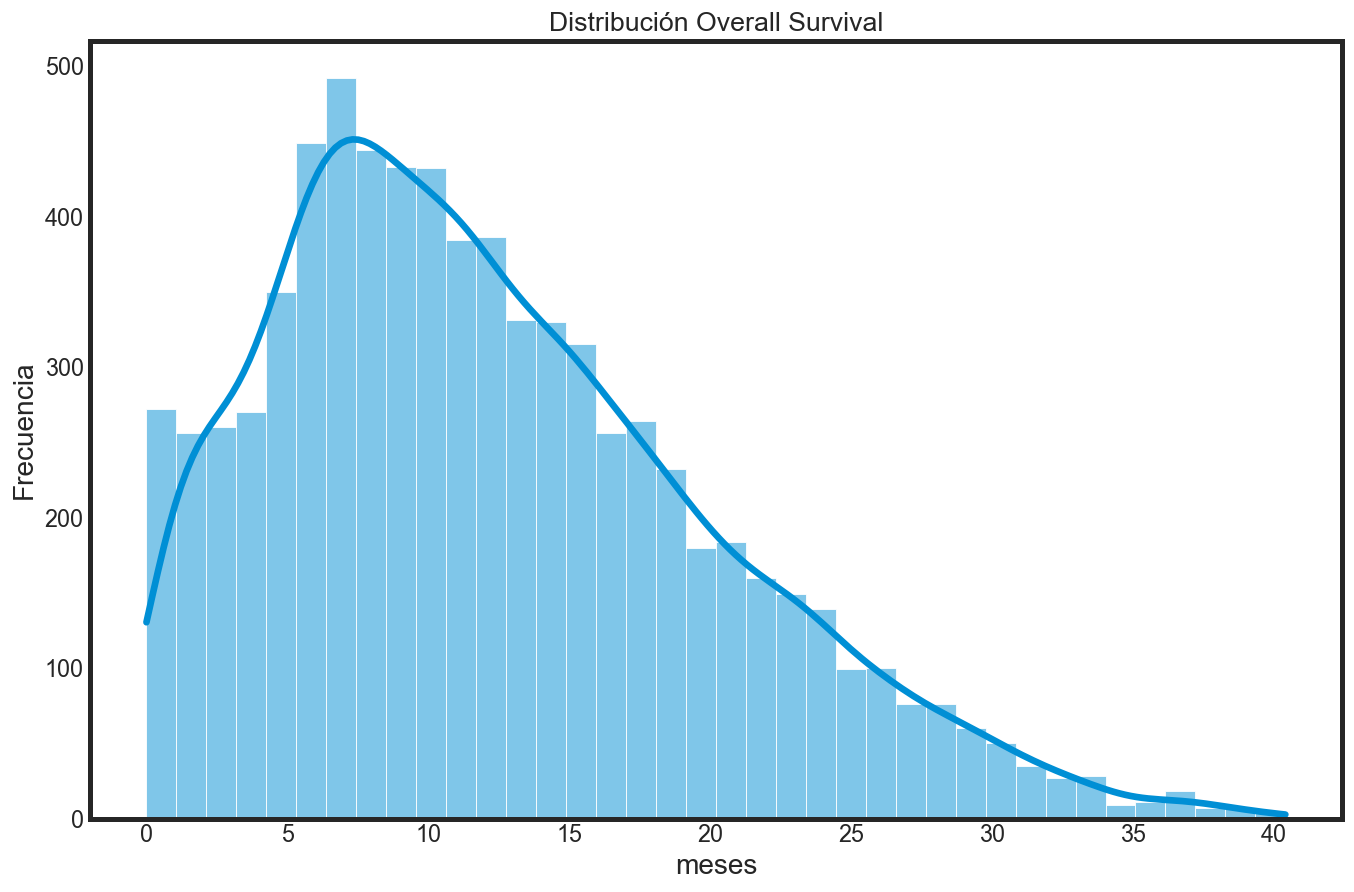

In [40]:
sns.histplot(wide['OS_MONTHS'].astype(float), kde=True)
plt.title('Distribución Overall Survival', fontsize=16)
plt.xlabel('meses')
plt.ylabel('Frecuencia')
plt.show()


In [48]:
# 1. Imputación por mediana para 'salario'
# La mediana es una opción segura porque no se ve afectada por los outliers
median_OSMONTHS = pd.to_numeric(wide['OS_MONTHS'], errors='coerce').median()
wide['OS_MONTHS'] = pd.to_numeric(wide['OS_MONTHS'], errors='coerce').fillna(median_salary)


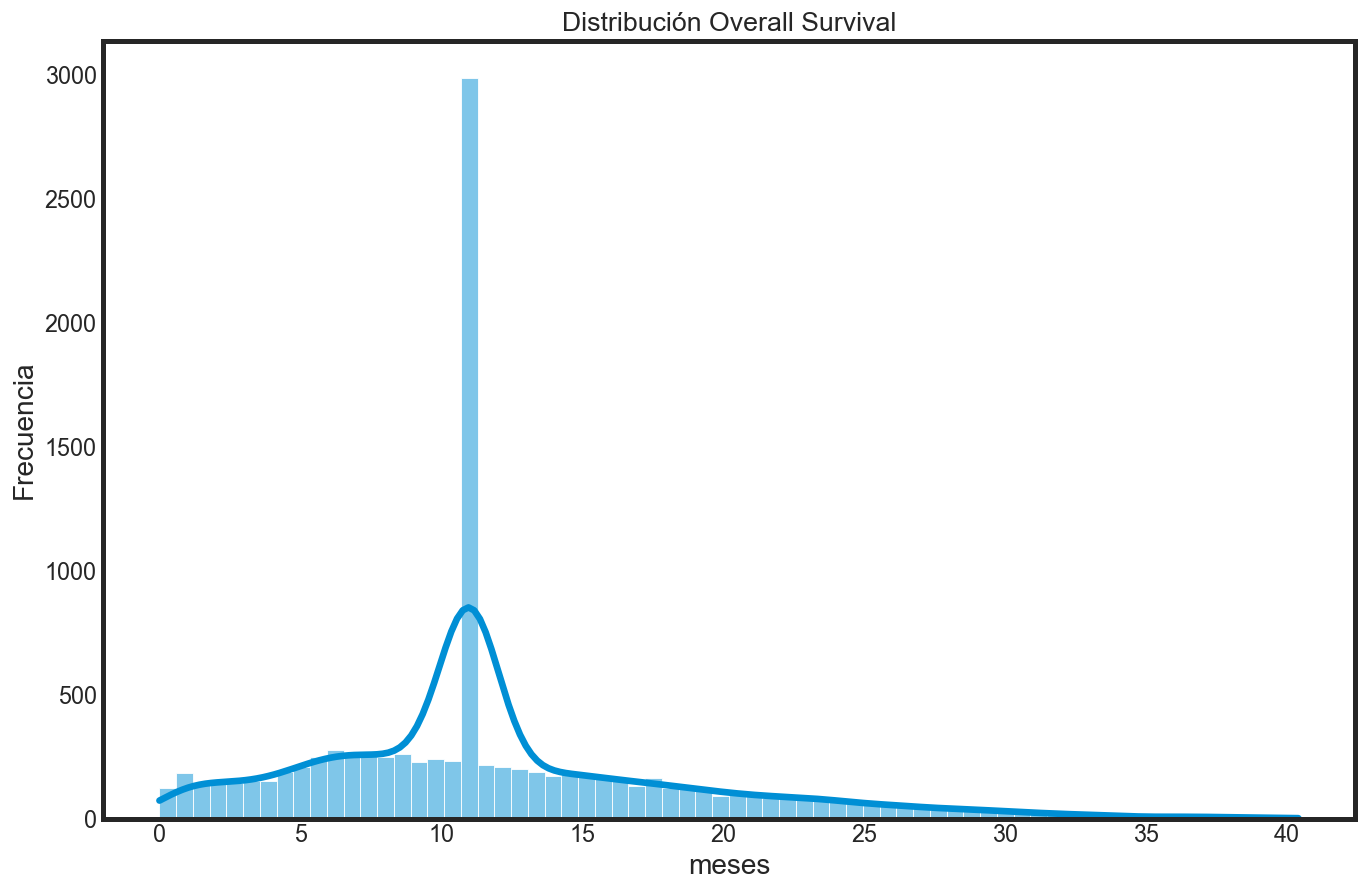

In [50]:
# Visualizar la distribución de 'salario' después de la imputación
sns.histplot(wide['OS_MONTHS'].astype(float), kde=True)
plt.title('Distribución Overall Survival', fontsize=16)
plt.xlabel('meses')
plt.ylabel('Frecuencia')
plt.show()

In [51]:
# Estadísticos básicos de OS (count, mean, std, min, Q1, mediana, Q3, max)
wide[["OS_MONTHS"]].describe()

clinicalAttributeId,OS_MONTHS
count,"10,336.00"
mean,11.93
std,6.64
min,0.00
25%,7.98
50%,10.98
75%,14.53
max,40.40


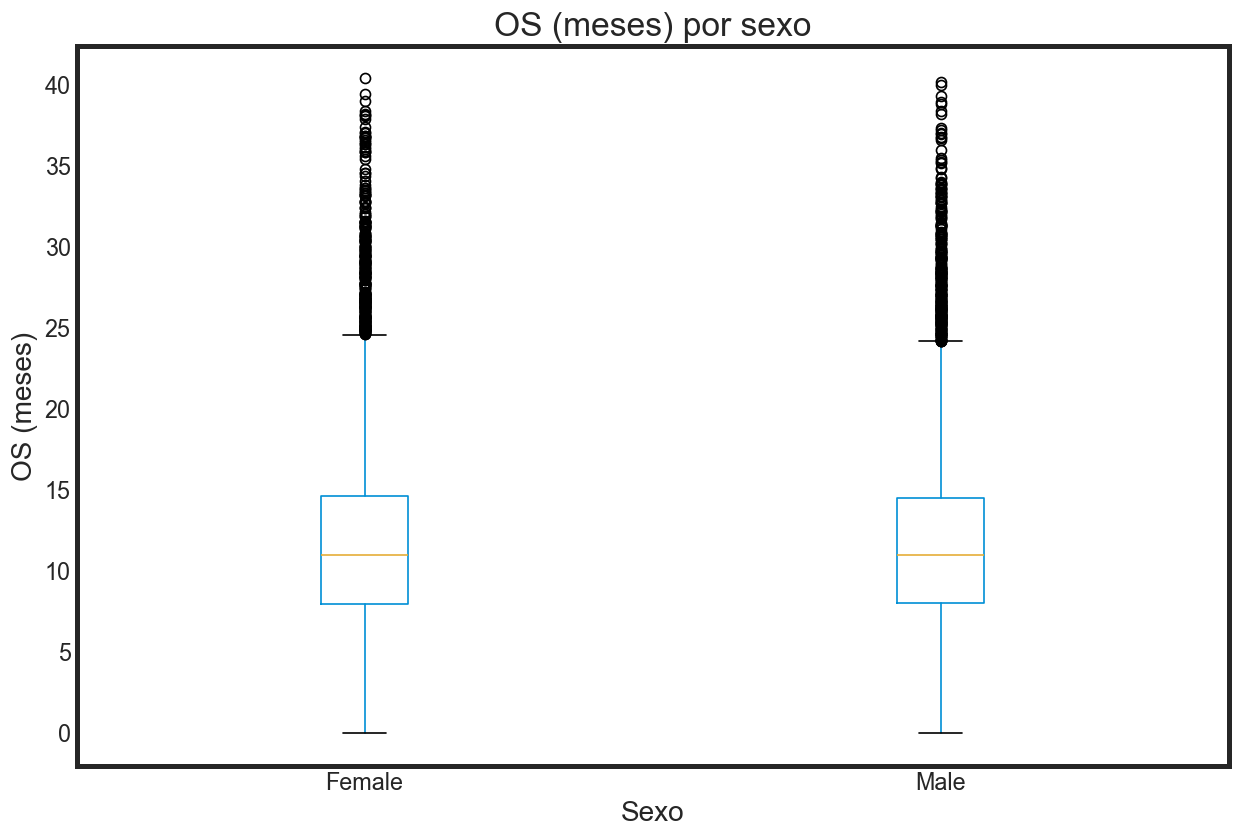

In [54]:
ok = wide.dropna(subset=["OS_MONTHS","SEX"])
ok.boxplot(column="OS_MONTHS", by="SEX", grid=False)
plt.title("OS (meses) por sexo"); plt.suptitle("")
plt.xlabel("Sexo"); plt.ylabel("OS (meses)")
plt.show()

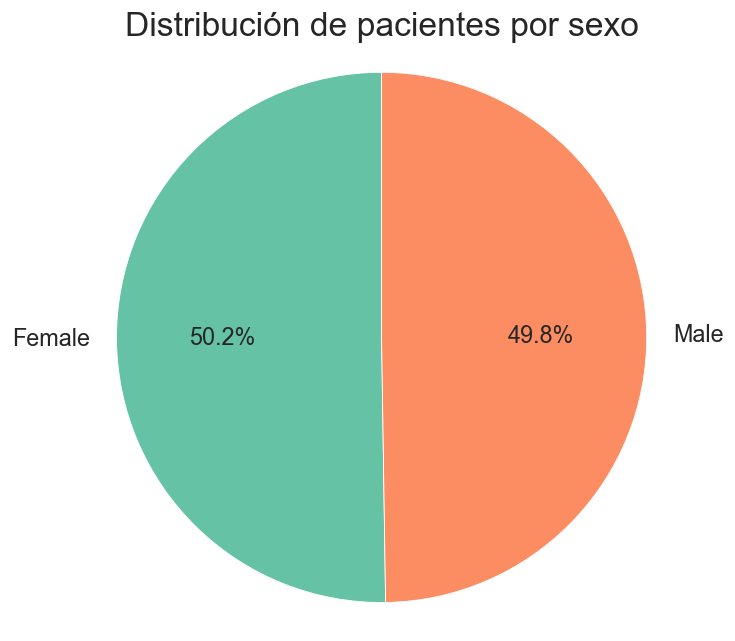

In [77]:
import matplotlib.pyplot as plt

# Conteo de frecuencias (incluye NaN como categoría si existe)
sexo_counts = wide["SEX"].value_counts(dropna=False)

# Etiquetas personalizadas (puedes traducirlas si lo deseas)
labels = sexo_counts.index.astype(str)
sizes = sexo_counts.values

# Colores opcionales
colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"]  # puedes ajustar según el número de categorías

# Crear gráfico
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
plt.title("Distribución de pacientes por sexo")
plt.axis("equal")  # Para que el gráfico sea circular
plt.show()


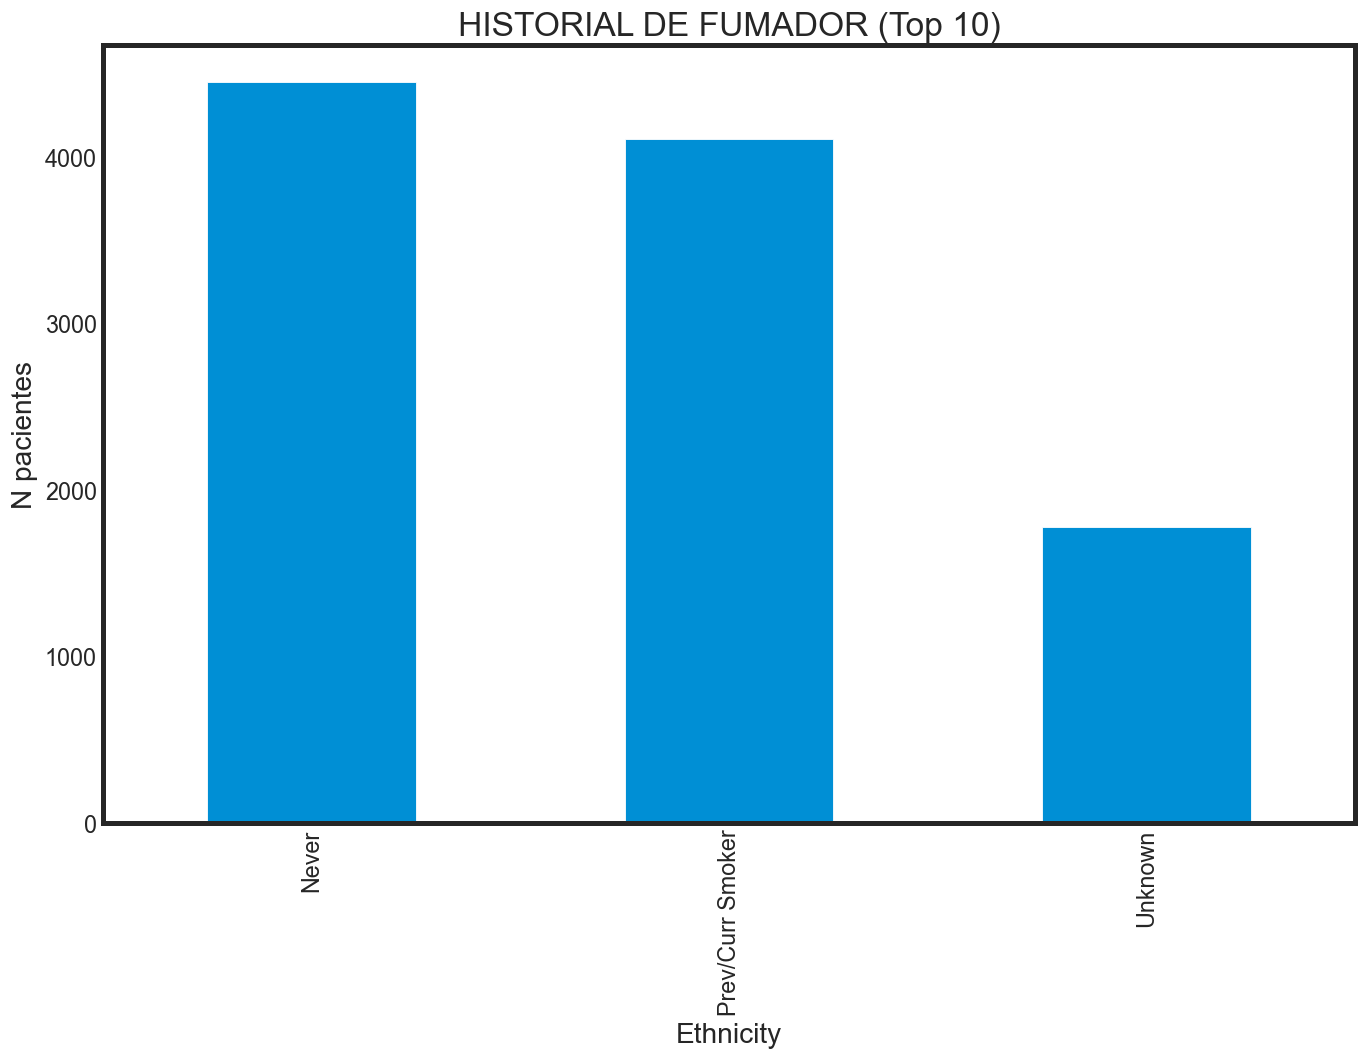

In [83]:
# Barras de HISTORIAL DE FUMADOR
if "SMOKING_HISTORY" in wide:
    wide["SMOKING_HISTORY"].dropna().value_counts().head(10).plot(kind="bar")
    plt.title("HISTORIAL DE FUMADOR (Top 10)")
    plt.xlabel("Ethnicity")
    plt.ylabel("N pacientes")
    plt.show()

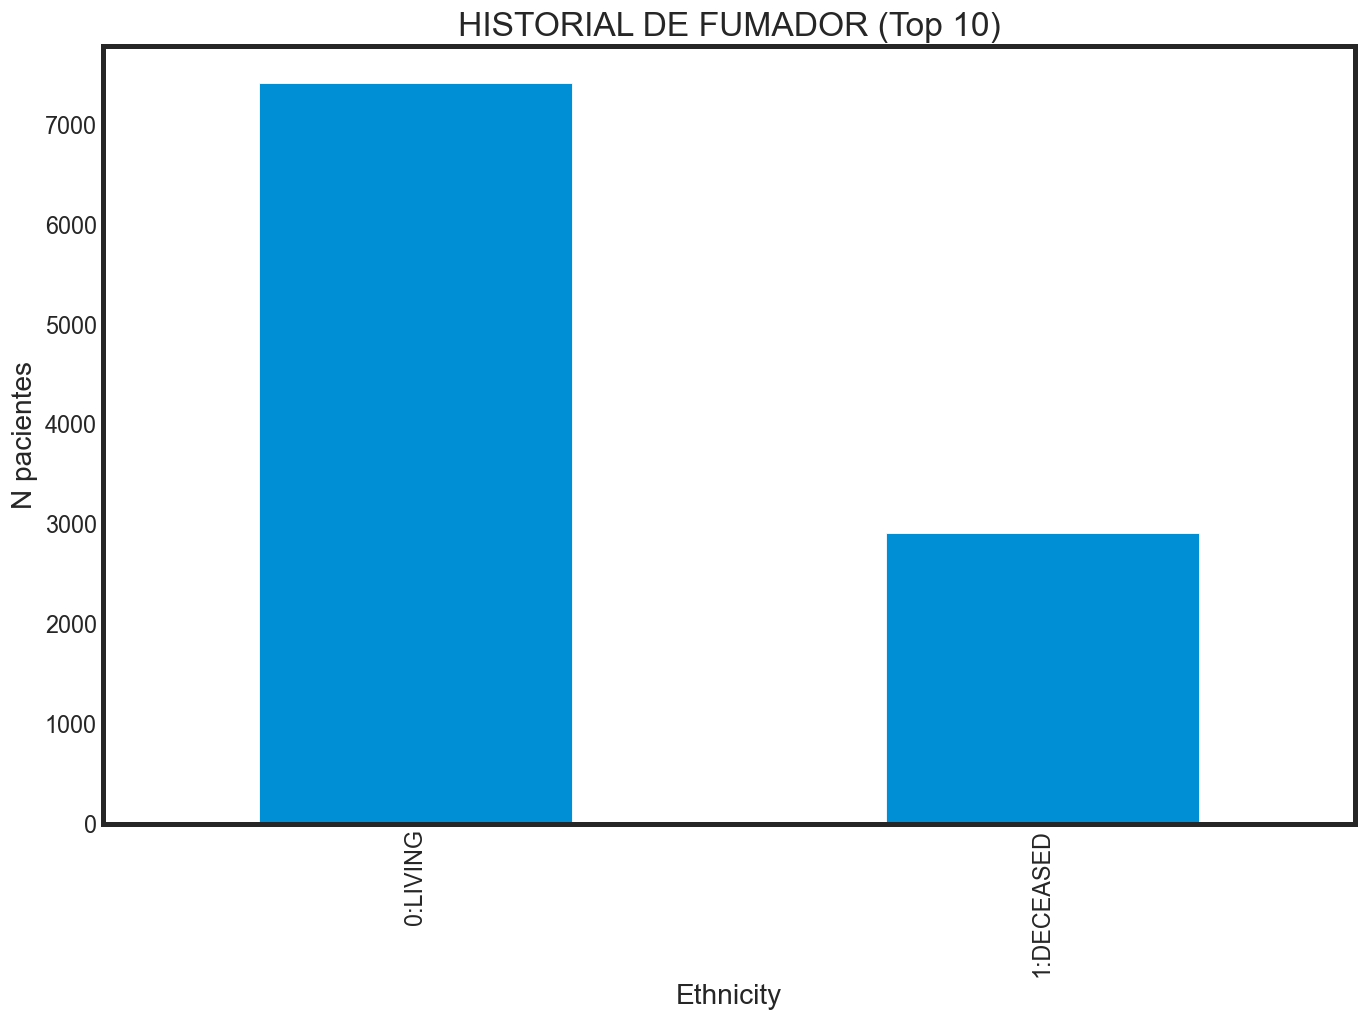

In [84]:
# Barras de ETHNICITY
if "OS_STATUS" in wide:
    wide["OS_STATUS"].dropna().value_counts().head(10).plot(kind="bar")
    plt.title("HISTORIAL DE FUMADOR (Top 10)")
    plt.xlabel("Ethnicity")
    plt.ylabel("N pacientes")
    plt.show()